In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cross_validation import train_test_split

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Домашняя работа 2

1. **Обязательная часть**: на том же наборе данных провести feature engineering:
    - создать Weights of Evidence (WOE) фичи на тех переменных, где категорий большое количество
    - cделать one hot encoding там, где необходимо
    - по желанию посчитать каунты (counts)
    
2. **Обязательная часть**: обучить linear SVM и SVM с нелинейным ядром - сравнить время обучения и результат метрики оценки качества (ROC AUC) двух алгоритмов между собой и сравнить с линейной моделью (лог.рег)

In [2]:
data_raw = pd.read_csv('train.csv')

In [3]:
data_raw.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [4]:
data_raw['Time_Stamp'] = pd.to_datetime(data_raw['TRDATETIME'], format='%d%b%y:%H:%M:%S')
data_raw['date'] = data_raw['Time_Stamp'].dt.date
data_raw['year'] = data_raw['Time_Stamp'].dt.year
data_raw['month'] = data_raw['Time_Stamp'].dt.month
data_raw['day_Month'] = data_raw['Time_Stamp'].dt.day
data_raw['day_Week'] = data_raw['Time_Stamp'].dt.weekday
data_raw['hour'] = data_raw['Time_Stamp'].dt.hour


# 1. **Обязательная часть**: на том же наборе данных провести feature engineering:
    - создать Weights of Evidence (WOE) фичи на тех переменных, где категорий большое количество
    - cделать one hot encoding там, где необходимо
    - по желанию посчитать каунты (counts)
    

In [5]:
def get_one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [6]:
data_raw = get_one_hot(
    data_raw,
    ['day_Week', 'hour']
#     ['year', 'month', 'day_Month', 'day_Week', 'hour']
)

In [7]:
data_raw.head(3)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
y_ = data_raw['target_flag'].copy()
#data_raw.drop(['target_flag'], inplace=True, axis=1)

In [9]:
data_train, data_test, y_train, y_test = train_test_split(data_raw, y_, test_size=0.3, random_state=0)

In [10]:
def get_woe_v1(df_train, df_test, col, target_col):
    all_good = len(df_train[df_train[target_col] == 1][col])
    all_bad = len(df_train[df_train[target_col] == 0][col])
    odds_series = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[df_train[target_col] == 0][col].value_counts()
    )
    odds_series = odds_series / all_good * all_bad
    category_woe_dict = np.log(odds_series).to_dict()
    df_train[col + '_woe'] = df_train[col].apply(category_woe_dict.get)
    df_test[col + '_woe'] = df_test[col].apply(category_woe_dict.get)
    return df_train, df_test

In [11]:
data_train.columns

Index(['PERIOD', 'cl_id', 'MCC', 'channel_type', 'currency', 'TRDATETIME',
       'amount', 'trx_category', 'target_flag', 'target_sum', 'Time_Stamp',
       'date', 'year', 'month', 'day_Month', 'day_Week', 'hour', 'day_Week_0',
       'day_Week_1', 'day_Week_2', 'day_Week_3', 'day_Week_4', 'day_Week_5',
       'day_Week_6', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

In [12]:
# columns_to_get_woe = [
#     'trx_category',
#     'year',
#     'month',
#     'day_Month',
#     'day_Week',
#     'hour',
#     'mcc_category'
# ]

In [13]:
columns_to_get_woe = [
    'MCC',
    'trx_category',
    'channel_type',
    'currency'
]

In [14]:
for col_get_prob in columns_to_get_woe:
    data_train, data_test = get_woe_v1(data_train, data_test, col_get_prob, 'target_flag')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [15]:
def get_counts(df_train, df_test, col, target_col):
    category_val_dict = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[col].value_counts()
    ).to_dict()
    df_train[col + '_counts'] = df_train[col].apply(category_val_dict.get)
    df_test[col + '_counts'] = df_test[col].apply(category_val_dict.get)
    return df_train, df_test

In [16]:
data_train, data_test = get_counts(data_train, data_test, 'amount', 'target_flag')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


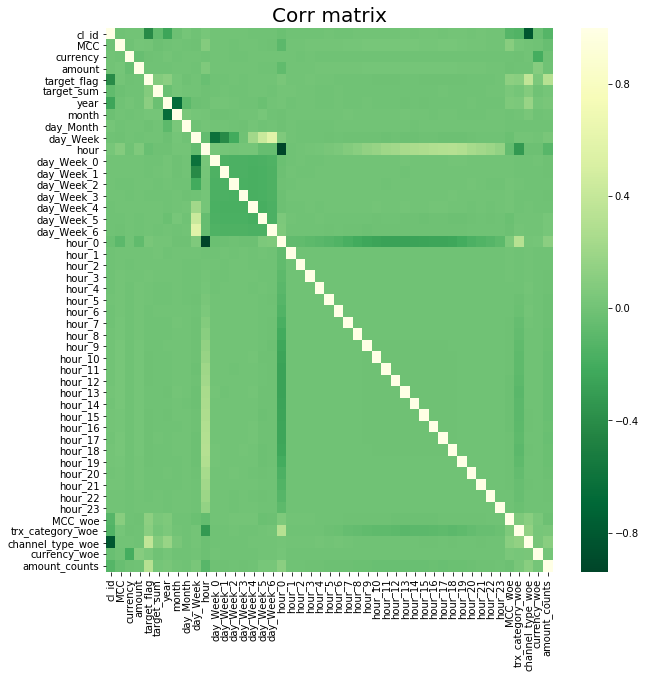

In [17]:
corr = data_train.corr()
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Corr matrix', size=20)
sns.heatmap(
    corr, 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    ax=ax, cmap = 'YlGn_r'
)
plt.show()

In [18]:
data_train.head(10)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,...,hour_19,hour_20,hour_21,hour_22,hour_23,MCC_woe,trx_category_woe,channel_type_woe,currency_woe,amount_counts
47247,01/09/2017,836,5499,type2,810,01SEP17:00:00:00,300.00,POS,1,404390.80,...,0,0,0,0,0,0.014792,0.014528,1.435761,-0.004073,0.713248
238729,01/01/2018,4445,6012,type1,810,17JAN18:11:44:47,1000.00,C2C_IN,0,0.00,...,0,0,0,0,0,-0.353472,-0.460100,-0.579714,-0.004073,0.659663
365180,01/01/2017,7353,6011,type1,810,05JAN17:15:05:41,13600.00,DEPOSIT,0,0.00,...,0,0,0,0,0,-0.008436,-0.780351,-0.579714,-0.004073,0.555556
185509,01/03/2018,3248,7995,type2,810,11MAR18:00:00:00,200.00,POS,1,310672.32,...,0,0,0,0,0,0.451160,0.014528,1.435761,-0.004073,0.687906
365559,01/12/2016,7355,5411,type1,810,17DEC16:00:00:00,104.41,POS,0,0.00,...,0,0,0,0,0,-0.139481,0.014528,-0.579714,-0.004073,NaN
430709,01/12/2016,8798,5411,type1,810,29DEC16:00:00:00,31.00,POS,0,0.00,...,0,0,0,0,0,-0.139481,0.014528,-0.579714,-0.004073,0.544715
161513,01/01/2017,2838,4111,type2,810,29JAN17:00:00:00,61.50,POS,0,0.00,...,0,0,0,0,0,0.218048,0.014528,1.435761,-0.004073,0.560606
433367,01/03/2017,8892,5641,type1,810,05MAR17:00:00:00,2558.50,POS,0,0.00,...,0,0,0,0,0,-0.145816,0.014528,-0.579714,-0.004073,NaN
480476,01/08/2017,9969,5621,type1,810,23AUG17:00:00:00,4190.00,POS,1,12757.18,...,0,0,0,0,0,-0.033671,0.014528,-0.579714,-0.004073,0.750000
280344,01/05/2017,5414,5912,type1,810,06MAY17:00:00:00,129.50,POS,1,240845.39,...,0,0,0,0,0,-0.058905,0.014528,-0.579714,-0.004073,0.473684


In [19]:
data_train['amount_counts'].fillna(0, inplace = True )

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [20]:
data_test['amount_counts'].fillna(0, inplace = True )

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [21]:
data_train.head(10)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,...,hour_19,hour_20,hour_21,hour_22,hour_23,MCC_woe,trx_category_woe,channel_type_woe,currency_woe,amount_counts
47247,01/09/2017,836,5499,type2,810,01SEP17:00:00:00,300.00,POS,1,404390.80,...,0,0,0,0,0,0.014792,0.014528,1.435761,-0.004073,0.713248
238729,01/01/2018,4445,6012,type1,810,17JAN18:11:44:47,1000.00,C2C_IN,0,0.00,...,0,0,0,0,0,-0.353472,-0.460100,-0.579714,-0.004073,0.659663
365180,01/01/2017,7353,6011,type1,810,05JAN17:15:05:41,13600.00,DEPOSIT,0,0.00,...,0,0,0,0,0,-0.008436,-0.780351,-0.579714,-0.004073,0.555556
185509,01/03/2018,3248,7995,type2,810,11MAR18:00:00:00,200.00,POS,1,310672.32,...,0,0,0,0,0,0.451160,0.014528,1.435761,-0.004073,0.687906
365559,01/12/2016,7355,5411,type1,810,17DEC16:00:00:00,104.41,POS,0,0.00,...,0,0,0,0,0,-0.139481,0.014528,-0.579714,-0.004073,0.000000
430709,01/12/2016,8798,5411,type1,810,29DEC16:00:00:00,31.00,POS,0,0.00,...,0,0,0,0,0,-0.139481,0.014528,-0.579714,-0.004073,0.544715
161513,01/01/2017,2838,4111,type2,810,29JAN17:00:00:00,61.50,POS,0,0.00,...,0,0,0,0,0,0.218048,0.014528,1.435761,-0.004073,0.560606
433367,01/03/2017,8892,5641,type1,810,05MAR17:00:00:00,2558.50,POS,0,0.00,...,0,0,0,0,0,-0.145816,0.014528,-0.579714,-0.004073,0.000000
480476,01/08/2017,9969,5621,type1,810,23AUG17:00:00:00,4190.00,POS,1,12757.18,...,0,0,0,0,0,-0.033671,0.014528,-0.579714,-0.004073,0.750000
280344,01/05/2017,5414,5912,type1,810,06MAY17:00:00:00,129.50,POS,1,240845.39,...,0,0,0,0,0,-0.058905,0.014528,-0.579714,-0.004073,0.473684


# 2. **Обязательная часть**: обучить linear SVM и SVM с нелинейным ядром - сравнить время обучения и результат метрики оценки качества (ROC AUC) двух алгоритмов между собой и сравнить с линейной моделью (лог.рег)

In [22]:
data_train.columns

Index(['PERIOD', 'cl_id', 'MCC', 'channel_type', 'currency', 'TRDATETIME',
       'amount', 'trx_category', 'target_flag', 'target_sum', 'Time_Stamp',
       'date', 'year', 'month', 'day_Month', 'day_Week', 'hour', 'day_Week_0',
       'day_Week_1', 'day_Week_2', 'day_Week_3', 'day_Week_4', 'day_Week_5',
       'day_Week_6', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'MCC_woe', 'trx_category_woe', 'channel_type_woe', 'currency_woe',
       'amount_counts'],
      dtype='object')

In [23]:
data_train_ = pd.DataFrame(data_train, columns = ['cl_id', 'day_Week_0', 'day_Week_1',
       'day_Week_2', 'day_Week_3', 'day_Week_4', 'day_Week_5', 'day_Week_6',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'MCC_woe',
       'trx_category_woe', 'channel_type_woe', 'currency_woe',
       'amount_counts'])

In [24]:
data_train_.head(1)

,cl_id,day_Week_0,day_Week_1,day_Week_2,day_Week_3,day_Week_4,day_Week_5,day_Week_6,hour_0,hour_1,...,hour_19,hour_20,hour_21,hour_22,hour_23,MCC_woe,trx_category_woe,channel_type_woe,currency_woe,amount_counts
47247,836,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0.014792,0.014528,1.435761,-0.004073,0.713248


In [25]:
data_train_.fillna(0, inplace=True)
data_train_.isnull().values.any()

False

In [26]:
from sklearn import preprocessing

In [27]:
scaler = preprocessing.StandardScaler()

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
    ("scaler", scaler),
    ("linear_svc", svm_clf1),
])
scaled_svm_clf1.fit(data_train_, y_)

ValueError: Found input variables with inconsistent numbers of samples: [343359, 490513]

In [29]:
!open .